In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 17:45:20.856232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:45:20.860294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:45:20.860611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 17:45:21.123811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 17:45:21.124494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:45:21.124856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:45:21.125150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[1.58801162e+00, 5.71773589e-01, 1.19011724e+00],
         [1.67925143e+00, 2.16154113e-01, 1.83411956e+00],
         [1.23045349e+00, 0.00000000e+00, 5.77062845e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 9.20124531e-01],
         [1.98511291e+00, 8.53754997e-01, 1.53483522e+00],
         [0.00000000e+00, 0.00000000e+00, 1.00638974e+00]],

        [[0.00000000e+00, 0.00000000e+00, 2.53461528e+00],
         [1.41997051e+00, 0.00000000e+00, 2.51694965e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.27468634e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.48594058e+00],
         [0.00000000e+00, 9.62624669e-01, 0.00000000e+00],
         ...,
         [0

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.58801162e+00, 5.71773589e-01, 1.19011724e+00],
          [1.67925143e+00, 2.16154113e-01, 1.83411956e+00],
          [1.23045349e+00, 0.00000000e+00, 5.77062845e-01],
          ...,
          [0.00000000e+00, 0.00000000e+00, 9.20124531e-01],
          [1.98511291e+00, 8.53754997e-01, 1.53483522e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00638974e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 2.53461528e+00],
          [1.41997051e+00, 0.00000000e+00, 2.51694965e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [1.27468634e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.48594058e+00],
          [0.00000000e+00, 9.62624669e-01, 0.00000000e+0

<IPython.core.display.Javascript object>


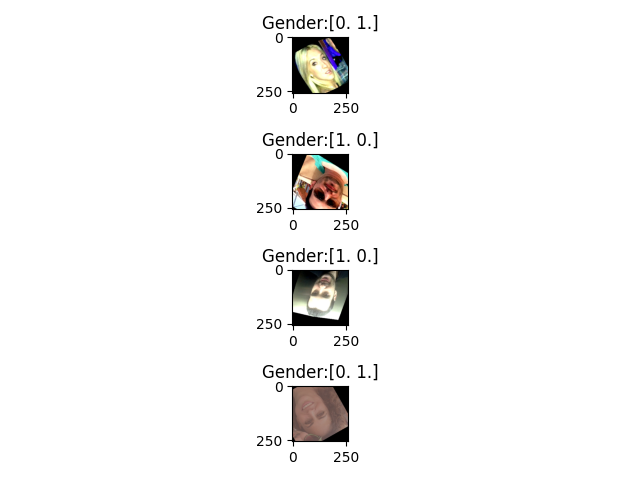

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 2, strides=(2,2), activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(8, 2, strides=(2,2), activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*8, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,8), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(32, 2, strides=(2,2), activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 2, strides=(2,2), activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    

    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_2')
    
    return model

In [33]:
LATENT_SIZE = 32

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 32)           60040       ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_3"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 700, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 17:45:24.789173: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 17:45:24.789191: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 17:45:24.789217: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 17:45:24.871332: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 17:45:24.872626: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 17:45:25.501939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  17/3528 [..............................] - ETA: 11s - loss: 5613.5312 - gender_out_loss: 0.6927 - tf.math.multiply_1_loss: 5612.8389 - gender_out_accuracy: 0.5294    

2022-11-01 17:45:26.219473: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 12s 3ms/step - loss: 5991.6572 - gender_out_loss: 0.6928 - tf.math.multiply_1_loss: 5990.9409 - gender_out_accuracy: 0.5183
Epoch 1/300
   1/1000 [..............................] - ETA: 13:50 - loss: 7316.8750 - gender_out_loss: 0.7014 - tf.math.multiply_1_loss: 7316.1733 - gender_out_accuracy: 0.2500

2022-11-01 17:45:37.764425: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 17:45:37.764602: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:18 - loss: 7429.2812 - gender_out_loss: 0.6996 - tf.math.multiply_1_loss: 7428.5811 - gender_out_accuracy: 0.3750

2022-11-01 17:45:38.279421: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 17:45:38.280480: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 17:45:38.313897: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2684 callback api events and 2643 activity events. 
2022-11-01 17:45:38.339300: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 17:45:38.377173: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_3/log_0/plugins/profile/2022_11_01_17_45_38

2022-11-01 17:45:38.428644: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_3/log_0/plugins/profile/2022_11_01_17_45_38/rachanon-pc1.trace.json.gz
2022-11-01 17:45:38.469202: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/A

1000/1000 [==============================] - 18s 17ms/step - loss: 6940.7061 - gender_out_loss: 1.4078 - tf.math.multiply_1_loss: 6939.2920 - gender_out_accuracy: 0.4972 - val_loss: 4935.9346 - val_gender_out_loss: 0.8436 - val_tf.math.multiply_1_loss: 4935.0962 - val_gender_out_accuracy: 0.5165
Epoch 2/300
1000/1000 [==============================] - 17s 17ms/step - loss: 4381.3091 - gender_out_loss: 4.4488 - tf.math.multiply_1_loss: 4376.8594 - gender_out_accuracy: 0.5115 - val_loss: 3996.2302 - val_gender_out_loss: 1.1220 - val_tf.math.multiply_1_loss: 3995.1047 - val_gender_out_accuracy: 0.5153
Epoch 3/300
1000/1000 [==============================] - 17s 17ms/step - loss: 3874.3779 - gender_out_loss: 3.9056 - tf.math.multiply_1_loss: 3870.4707 - gender_out_accuracy: 0.5160 - val_loss: 3845.1367 - val_gender_out_loss: 0.9690 - val_tf.math.multiply_1_loss: 3844.1709 - val_gender_out_accuracy: 0.4785
Epoch 4/300
1000/1000 [==============================] - 17s 17ms/step - loss: 3789.3

1000/1000 [==============================] - 17s 17ms/step - loss: 1913.1492 - gender_out_loss: 0.8506 - tf.math.multiply_1_loss: 1912.3013 - gender_out_accuracy: 0.5217 - val_loss: 2167.5913 - val_gender_out_loss: 0.7051 - val_tf.math.multiply_1_loss: 2166.8855 - val_gender_out_accuracy: 0.5586
Epoch 28/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2010.7075 - gender_out_loss: 0.8457 - tf.math.multiply_1_loss: 2009.8644 - gender_out_accuracy: 0.5063 - val_loss: 2156.8911 - val_gender_out_loss: 0.6958 - val_tf.math.multiply_1_loss: 2156.1978 - val_gender_out_accuracy: 0.5576
Epoch 29/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1958.4847 - gender_out_loss: 0.8115 - tf.math.multiply_1_loss: 1957.6716 - gender_out_accuracy: 0.5130 - val_loss: 2134.0403 - val_gender_out_loss: 0.6922 - val_tf.math.multiply_1_loss: 2133.3486 - val_gender_out_accuracy: 0.5572
Epoch 30/300
1000/1000 [==============================] - 17s 17ms/step - loss: 190

1000/1000 [==============================] - 17s 17ms/step - loss: 1732.8265 - gender_out_loss: 0.7003 - tf.math.multiply_1_loss: 1732.1268 - gender_out_accuracy: 0.5320 - val_loss: 1902.1907 - val_gender_out_loss: 0.6781 - val_tf.math.multiply_1_loss: 1901.5149 - val_gender_out_accuracy: 0.5566
Epoch 54/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1673.5590 - gender_out_loss: 0.6988 - tf.math.multiply_1_loss: 1672.8593 - gender_out_accuracy: 0.5210 - val_loss: 1906.2173 - val_gender_out_loss: 0.6751 - val_tf.math.multiply_1_loss: 1905.5382 - val_gender_out_accuracy: 0.5841
Epoch 55/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1732.4524 - gender_out_loss: 0.6960 - tf.math.multiply_1_loss: 1731.7576 - gender_out_accuracy: 0.5197 - val_loss: 1900.2378 - val_gender_out_loss: 0.6752 - val_tf.math.multiply_1_loss: 1899.5653 - val_gender_out_accuracy: 0.5759
Epoch 56/300
1000/1000 [==============================] - 17s 17ms/step - loss: 170

1000/1000 [==============================] - 17s 17ms/step - loss: 1615.6559 - gender_out_loss: 0.6937 - tf.math.multiply_1_loss: 1614.9617 - gender_out_accuracy: 0.5335 - val_loss: 1821.8940 - val_gender_out_loss: 0.6780 - val_tf.math.multiply_1_loss: 1821.2153 - val_gender_out_accuracy: 0.5704
Epoch 80/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1591.2151 - gender_out_loss: 0.6829 - tf.math.multiply_1_loss: 1590.5316 - gender_out_accuracy: 0.5655 - val_loss: 1820.9369 - val_gender_out_loss: 0.6815 - val_tf.math.multiply_1_loss: 1820.2589 - val_gender_out_accuracy: 0.5450
Epoch 81/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1667.8069 - gender_out_loss: 0.6922 - tf.math.multiply_1_loss: 1667.1154 - gender_out_accuracy: 0.5378 - val_loss: 1817.9348 - val_gender_out_loss: 0.6810 - val_tf.math.multiply_1_loss: 1817.2554 - val_gender_out_accuracy: 0.5462
Epoch 82/300
1000/1000 [==============================] - 17s 17ms/step - loss: 168

1000/1000 [==============================] - 17s 17ms/step - loss: 1594.9783 - gender_out_loss: 0.6812 - tf.math.multiply_1_loss: 1594.2961 - gender_out_accuracy: 0.5888 - val_loss: 1771.6941 - val_gender_out_loss: 0.6810 - val_tf.math.multiply_1_loss: 1771.0116 - val_gender_out_accuracy: 0.5484
Epoch 106/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1607.5226 - gender_out_loss: 0.6937 - tf.math.multiply_1_loss: 1606.8311 - gender_out_accuracy: 0.5190 - val_loss: 1777.8828 - val_gender_out_loss: 0.6806 - val_tf.math.multiply_1_loss: 1777.1984 - val_gender_out_accuracy: 0.5518
Epoch 107/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1583.4657 - gender_out_loss: 0.6903 - tf.math.multiply_1_loss: 1582.7743 - gender_out_accuracy: 0.5312 - val_loss: 1767.4088 - val_gender_out_loss: 0.6797 - val_tf.math.multiply_1_loss: 1766.7267 - val_gender_out_accuracy: 0.5613
Epoch 108/300
1000/1000 [==============================] - 16s 16ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 1591.0837 - gender_out_loss: 0.6841 - tf.math.multiply_1_loss: 1590.3994 - gender_out_accuracy: 0.5527 - val_loss: 1739.6859 - val_gender_out_loss: 0.6804 - val_tf.math.multiply_1_loss: 1739.0073 - val_gender_out_accuracy: 0.5513
Epoch 132/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1502.7797 - gender_out_loss: 0.6898 - tf.math.multiply_1_loss: 1502.0902 - gender_out_accuracy: 0.5330 - val_loss: 1735.6963 - val_gender_out_loss: 0.6794 - val_tf.math.multiply_1_loss: 1735.0170 - val_gender_out_accuracy: 0.5641
Epoch 133/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1491.0907 - gender_out_loss: 0.6824 - tf.math.multiply_1_loss: 1490.4072 - gender_out_accuracy: 0.5667 - val_loss: 1733.4615 - val_gender_out_loss: 0.6821 - val_tf.math.multiply_1_loss: 1732.7808 - val_gender_out_accuracy: 0.5438
Epoch 134/300
1000/1000 [==============================] - 16s 16ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 1517.2959 - gender_out_loss: 0.6896 - tf.math.multiply_1_loss: 1516.6067 - gender_out_accuracy: 0.5195 - val_loss: 1717.1279 - val_gender_out_loss: 0.6798 - val_tf.math.multiply_1_loss: 1716.4469 - val_gender_out_accuracy: 0.5738
Epoch 158/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1510.2933 - gender_out_loss: 0.6801 - tf.math.multiply_1_loss: 1509.6122 - gender_out_accuracy: 0.5830 - val_loss: 1712.8286 - val_gender_out_loss: 0.6824 - val_tf.math.multiply_1_loss: 1712.1510 - val_gender_out_accuracy: 0.5416
Epoch 159/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1568.4315 - gender_out_loss: 0.6914 - tf.math.multiply_1_loss: 1567.7402 - gender_out_accuracy: 0.5325 - val_loss: 1710.7645 - val_gender_out_loss: 0.6811 - val_tf.math.multiply_1_loss: 1710.0824 - val_gender_out_accuracy: 0.5458
Epoch 160/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 1522.9637 - gender_out_loss: 0.6846 - tf.math.multiply_1_loss: 1522.2791 - gender_out_accuracy: 0.5565 - val_loss: 1691.5013 - val_gender_out_loss: 0.6807 - val_tf.math.multiply_1_loss: 1690.8209 - val_gender_out_accuracy: 0.5482
Epoch 184/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1534.4565 - gender_out_loss: 0.6886 - tf.math.multiply_1_loss: 1533.7668 - gender_out_accuracy: 0.5470 - val_loss: 1686.7502 - val_gender_out_loss: 0.6807 - val_tf.math.multiply_1_loss: 1686.0728 - val_gender_out_accuracy: 0.5499
Epoch 185/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1499.8450 - gender_out_loss: 0.6878 - tf.math.multiply_1_loss: 1499.1565 - gender_out_accuracy: 0.5350 - val_loss: 1685.9642 - val_gender_out_loss: 0.6797 - val_tf.math.multiply_1_loss: 1685.2889 - val_gender_out_accuracy: 0.5648
Epoch 186/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 16s 16ms/step - loss: 1478.0145 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 1477.3232 - gender_out_accuracy: 0.5157 - val_loss: 1665.1660 - val_gender_out_loss: 0.6784 - val_tf.math.multiply_1_loss: 1664.4854 - val_gender_out_accuracy: 0.5577
Epoch 210/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1470.1062 - gender_out_loss: 0.6909 - tf.math.multiply_1_loss: 1469.4158 - gender_out_accuracy: 0.5255 - val_loss: 1666.1576 - val_gender_out_loss: 0.6775 - val_tf.math.multiply_1_loss: 1665.4803 - val_gender_out_accuracy: 0.5756
Epoch 211/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1470.1923 - gender_out_loss: 0.6791 - tf.math.multiply_1_loss: 1469.5149 - gender_out_accuracy: 0.5717 - val_loss: 1665.1543 - val_gender_out_loss: 0.6782 - val_tf.math.multiply_1_loss: 1664.4752 - val_gender_out_accuracy: 0.5562
Epoch 212/300
1000/1000 [==============================] - 16s 16ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 1430.6320 - gender_out_loss: 0.6935 - tf.math.multiply_1_loss: 1429.9387 - gender_out_accuracy: 0.5310 - val_loss: 1650.3256 - val_gender_out_loss: 0.6782 - val_tf.math.multiply_1_loss: 1649.6479 - val_gender_out_accuracy: 0.5580
Epoch 236/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1483.7306 - gender_out_loss: 0.6875 - tf.math.multiply_1_loss: 1483.0421 - gender_out_accuracy: 0.5445 - val_loss: 1655.8942 - val_gender_out_loss: 0.6783 - val_tf.math.multiply_1_loss: 1655.2186 - val_gender_out_accuracy: 0.5552
Epoch 237/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1458.2329 - gender_out_loss: 0.6876 - tf.math.multiply_1_loss: 1457.5441 - gender_out_accuracy: 0.5387 - val_loss: 1647.2604 - val_gender_out_loss: 0.6781 - val_tf.math.multiply_1_loss: 1646.5808 - val_gender_out_accuracy: 0.5601
Epoch 238/300
1000/1000 [==============================] - 16s 17ms/step - loss: 

1000/1000 [==============================] - 16s 16ms/step - loss: 1522.1139 - gender_out_loss: 0.6897 - tf.math.multiply_1_loss: 1521.4240 - gender_out_accuracy: 0.5405 - val_loss: 1632.9924 - val_gender_out_loss: 0.6819 - val_tf.math.multiply_1_loss: 1632.3126 - val_gender_out_accuracy: 0.5414
Epoch 262/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1469.3557 - gender_out_loss: 0.6921 - tf.math.multiply_1_loss: 1468.6635 - gender_out_accuracy: 0.5210 - val_loss: 1631.8522 - val_gender_out_loss: 0.6777 - val_tf.math.multiply_1_loss: 1631.1721 - val_gender_out_accuracy: 0.5580
Epoch 263/300
1000/1000 [==============================] - 17s 17ms/step - loss: 1466.2177 - gender_out_loss: 0.6902 - tf.math.multiply_1_loss: 1465.5255 - gender_out_accuracy: 0.5245 - val_loss: 1638.3302 - val_gender_out_loss: 0.6773 - val_tf.math.multiply_1_loss: 1637.6541 - val_gender_out_accuracy: 0.5610
Epoch 264/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 16s 16ms/step - loss: 1401.2023 - gender_out_loss: 0.6897 - tf.math.multiply_1_loss: 1400.5127 - gender_out_accuracy: 0.5297 - val_loss: 1617.0576 - val_gender_out_loss: 0.6752 - val_tf.math.multiply_1_loss: 1616.3821 - val_gender_out_accuracy: 0.5695
Epoch 288/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1420.0154 - gender_out_loss: 0.6878 - tf.math.multiply_1_loss: 1419.3274 - gender_out_accuracy: 0.5552 - val_loss: 1619.3120 - val_gender_out_loss: 0.6802 - val_tf.math.multiply_1_loss: 1618.6298 - val_gender_out_accuracy: 0.5429
Epoch 289/300
1000/1000 [==============================] - 16s 16ms/step - loss: 1468.7037 - gender_out_loss: 0.6885 - tf.math.multiply_1_loss: 1468.0159 - gender_out_accuracy: 0.5437 - val_loss: 1617.8250 - val_gender_out_loss: 0.6781 - val_tf.math.multiply_1_loss: 1617.1455 - val_gender_out_accuracy: 0.5480
Epoch 290/300
1000/1000 [==============================] - 16s 16ms/step - loss: 

In [43]:
out = model(x)

In [44]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.29512250e-01, 2.99059153e-01, 2.58294940e-01],
          [1.12929940e-01, 2.55733877e-01, 3.16386223e-01],
          [2.17074752e-01, 3.47468555e-01, 2.56486237e-01],
          ...,
          [1.07967407e-01, 2.26878226e-01, 3.11993659e-01],
          [2.15106457e-01, 3.15459073e-01, 2.40869075e-01],
          [1.30310208e-01, 2.41439044e-01, 2.64982581e-01]],
 
         [[1.70504451e-01, 2.02855915e-01, 2.02665925e-01],
          [1.39498115e-01, 3.09341401e-01, 3.66292745e-01],
          [2.64860988e-01, 2.82036066e-01, 3.19456458e-01],
          ...,
          [1.27361566e-01, 2.92135924e-01, 3.00389081e-01],
          [2.40261108e-01, 2.90456414e-01, 3.08748633e-01],
          [1.82382613e-01, 2.97060460e-01, 2.69876719e-01]],
 
         [[2.91163176e-01, 3.81066352e-01, 8.75853002e-02],
          [1.85658038e-01, 2.52314061e-01, 3.41069698e-01],
          [2.59936452e-01, 3.02927345e-01, 3.42574418e-0

<IPython.core.display.Javascript object>


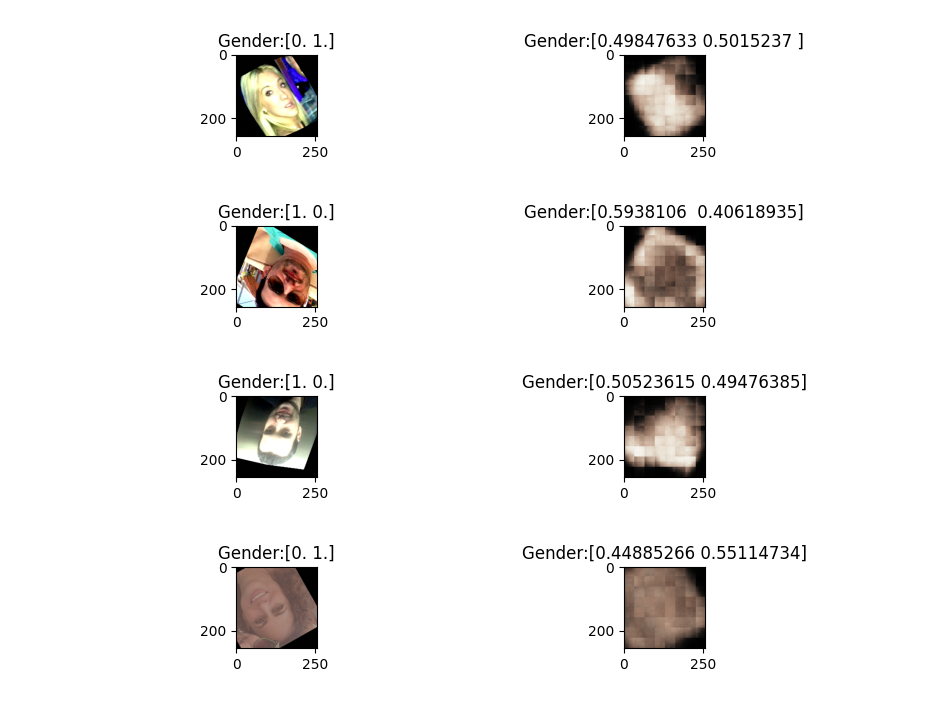

In [45]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()